In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')

# Function to compute score
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

# Load Data

In [2]:
df = pd.read_csv("ames.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


# Choose Features for Encoding

In [3]:
# Coint number of unique categories in each object column
onject_num_unique = df.select_dtypes(["object"]).nunique()
onject_num_unique

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       6
SaleType         10
SaleCondition     6
dtype: int64

In [4]:
onject_num_unique[onject_num_unique >= 10]

MSSubClass      16
Neighborhood    28
OverallQual     10
Exterior1st     16
Exterior2nd     17
SaleType        10
dtype: int64

In [5]:
# Select features with high amount of uniaue categories, we will encode them
features_to_encode = onject_num_unique[onject_num_unique >= 10].index
features_to_encode

Index(['MSSubClass', 'Neighborhood', 'OverallQual', 'Exterior1st',
       'Exterior2nd', 'SaleType'],
      dtype='object')

In [6]:
# To avoid overfitting, we need to fit the encoder on data heldout from the training set.

# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

# Apply M-Estimate Encoding

In [7]:
# Create the MEstimateEncoder
# Choose a set of features to encode and a value for m

encoder = MEstimateEncoder(cols=features_to_encode, m=5.0)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

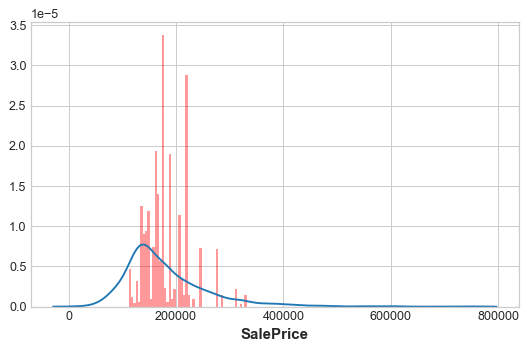

In [8]:
# Visualize encoded features to see how the encoded feature compares to the target
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

In [9]:
# Show the score of the encoded set compared to the original set
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1428 RMSLE
Score with Encoding: 0.1410 RMSLE
